In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple
import copy

In [ ]:
MAX_DIST = 2147483647
random.seed(100)

In [ ]:
def calculate_distance(nodes, node1, node2) -> int:
    x1, y1, _ = nodes[node1]
    x2, y2, _ = nodes[node2]
    return round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))

In [ ]:
def create_distance_matrix(nodes) -> np.ndarray:
    matrix = np.zeros(shape=(len(nodes), len(nodes)), dtype=np.int32)
    np.fill_diagonal(matrix, MAX_DIST)
    for node_index_1 in range(len(nodes) - 1):
        for node_index_2 in range(node_index_1 + 1, len(nodes)):
            distance = calculate_distance(nodes, node_index_1, node_index_2)
            matrix[node_index_1, node_index_2] = distance
            matrix[node_index_2, node_index_1] = distance
    return matrix

In [ ]:
def evaluate(distance_matrix: np.ndarray, path: list, costs: list) -> int:
    total_length = 0
    for i in range(len(path) - 1):
        total_length += distance_matrix[path[i], path[i + 1]] + costs[path[i]]
    score = total_length
    return score

In [ ]:
def random_solution(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1
    path = random.sample(list(range(distance_matrix.shape[0])), num_selected)
    path = path + [path[0]]
    return path

In [ ]:
def nearest_neighbor(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = math.ceil(n / 2)

    distance_matrix_copy = distance_matrix.copy()

    current_node_index = start_node

    path = [current_node_index]

    while len(path) < num_selected:

        current_node_distances = distance_matrix_copy[current_node_index, :]

        total_scores = current_node_distances + costs
        closest_node_index = np.argmin(total_scores)

        distance_matrix_copy[current_node_index, :] = MAX_DIST
        distance_matrix_copy[:, current_node_index] = MAX_DIST

        path.append(closest_node_index)
        current_node_index = closest_node_index

    path = path + [path[0]]

    return path

In [ ]:
def greedy_cycle(D, costs, start_node):
    path = [start_node]
    current_node_distances = D[start_node, :]
    total_scores = current_node_distances + costs
    best_neighbour = np.argmin(total_scores)
    path = path + [best_neighbour]
    path = path + [path[0]]

    target_length = math.ceil(len(D) / 2)

    nodes_selected = {start_node, best_neighbour}
    nodes_available = set(list(range(D.shape[0]))) - nodes_selected

    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length + 1:
        best_node = None
        replaced_edge = None
        best_increase = MAX_DIST
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            indices = np.array(list(nodes_available))
            elements = var[indices]
            new_node = indices[np.argmin(elements)]
            curr_increase = var[new_node]
            if curr_increase < best_increase:
                best_increase = curr_increase
                best_node = new_node
                replaced_edge = edge_ix

        path.insert(replaced_edge + 1, best_node)
        nodes_selected.add(best_node)
        nodes_available = nodes_available - nodes_selected
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])
    return path

In [ ]:
def greedy_regret(D, costs, start_node):
    best_neighbour = np.argmin(D[start_node, :] + costs)
    path = [start_node, best_neighbour, start_node]
    target_length = math.ceil(len(D) / 2)
    nodes_available = [x for x in list(range(D.shape[0])) if x not in path]
    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length+1:
        M = np.zeros((len(nodes_available), len(edges)))
        indices = np.array(nodes_available)
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            M[:,edge_ix] = var[indices]

        best_regret = -MAX_DIST
        replaced_edge = 0
        best_node = 0
        for node_idx in range(len(nodes_available)):
            sorted_indices = np.argsort(M[node_idx,:])
            best_edge_idx = sorted_indices[0]
            second_best_edge_idx = sorted_indices[1]
            regret = M[node_idx, best_edge_idx] - M[node_idx, second_best_edge_idx]
            if regret > best_regret:
                best_regret = regret
                replaced_edge = best_edge_idx
                best_node = nodes_available[node_idx]

        path.insert(replaced_edge+1, best_node)
        nodes_available.remove(best_node)
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])

    return path

In [ ]:
def greedy_weighted_regret(D, costs, start_node):
    best_neighbour = np.argmin(D[start_node, :] + costs)
    path = [start_node, best_neighbour, start_node]
    target_length = math.ceil(len(D) / 2)
    nodes_available = [x for x in list(range(D.shape[0])) if x not in path]
    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length+1:
        current_score = evaluate(D, path, costs)
        M = np.zeros((len(nodes_available), len(edges)))
        indices = np.array(nodes_available)
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            M[:,edge_ix] = var[indices]

        best_score = -MAX_DIST
        replaced_edge = 0
        best_node = 0
        for node_idx in range(len(nodes_available)):
            sorted_indices = np.argsort(M[node_idx,:])
            best_edge_idx = sorted_indices[0]
            second_best_edge_idx = sorted_indices[1]
            regret = M[node_idx, best_edge_idx] - M[node_idx, second_best_edge_idx]
            tmp_path = path[:]
            tmp_path.insert(best_edge_idx+1, nodes_available[node_idx])
            increase = evaluate(D, tmp_path, costs) - current_score
            score = 0.5*regret - 0.5*increase
            if score > best_score:
                best_score = score
                replaced_edge = best_edge_idx
                best_node = nodes_available[node_idx]

        path.insert(replaced_edge+1, best_node)
        nodes_available.remove(best_node)
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])

    return path

In [ ]:
def get_plot_values(nodes : Dict[int, Tuple[int, int, int]], solution: List[int], costs: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    x_coords = [nodes[node][0] for node in list(nodes.keys())]
    y_coords = [nodes[node][1] for node in list(nodes.keys())]
    path_x_coords = [nodes[node][0] for node in solution]
    path_y_coords = [nodes[node][1] for node in solution]
    new_costs = [(cost/max(costs))*100 for cost in costs]
    min_cost, max_cost = min(costs), max(costs)
    power = 2
    normalized_costs = [((cost - min_cost) / (max_cost - min_cost)) ** power for cost in costs]
    colors = plt.cm.RdBu(normalized_costs)
    return x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors

In [ ]:
def run_experiment(nodes: Dict[int, Tuple[int, int, int]], distance_matrix: np.ndarray, costs: List[int]) -> None:
  function_mapping = {
      # 'random_algorithm' : random_solution,
      # 'nearest_neighbor' : nearest_neighbor,
      # 'greedy_cycle' : greedy_cycle,
      'greedy_regret' : greedy_regret,
      'greedy_regret_weighted': greedy_weighted_regret
  }

  fig, axes = plt.subplots(1, len(function_mapping), figsize=(15, 5))
  i = 0
  for function_name in list(function_mapping.keys()):
    function = function_mapping[function_name]
    paths = []
    results = []
    for starting_node in range(200):
        path = function(distance_matrix, costs, starting_node)
        score = evaluate(distance_matrix, path, costs)
        paths.append(path)
        results.append(score)

    min_objective = min(results)
    best_solution = paths[np.argmin(results)]
    max_objective = max(results)
    average_objective = sum(results) / len(results)
    print(f'\n{function_name} results:\n')
    print("Max score:", max_objective)
    print("Average score:", average_objective)
    print("Min/Best score:", min_objective)
    print("Selected Nodes:", best_solution)
    x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors = get_plot_values(nodes, best_solution, costs)
    axes[i].scatter(x_coords, y_coords, color=colors, marker='o', s=new_costs, label='Cities')
    axes[i].plot(path_x_coords, path_y_coords, linestyle='-', marker='o', markersize=0, color='blue', label='Path', alpha=0.7)
    axes[i].set_title(f"Best {function_name} solution")
    i += 1


In [ ]:
def get_solution(filename: str) -> None:
  df = pd.read_csv(filename, names=["x", "y", "cost"], sep=';', header=None)
  print(f'Instance: {filename}')
  nodes = {}
  costs = []
  for idx, row in enumerate(df.values):
      x, y, cost = map(int, row)
      costs.append(cost)
      nodes[idx] = (x, y, cost)
  costs = [nodes[node][2] for node in list(nodes.keys())]
  distance_matrix = create_distance_matrix(nodes)
  run_experiment(nodes, distance_matrix, costs)


Instance: TSPA.csv

greedy_regret results:

Max score: 138825
Average score: 128104.335
Min/Best score: 113769
Selected Nodes: [119, 109, 196, 5, 112, 172, 24, 141, 102, 87, 67, 184, 21, 157, 170, 129, 120, 62, 146, 32, 180, 81, 154, 133, 44, 144, 6, 156, 98, 190, 72, 42, 197, 111, 14, 107, 168, 80, 8, 95, 31, 51, 135, 91, 50, 149, 69, 38, 37, 143, 63, 96, 147, 27, 116, 70, 25, 166, 142, 61, 182, 7, 183, 56, 181, 85, 132, 36, 113, 163, 74, 195, 47, 117, 28, 22, 115, 0, 19, 43, 121, 114, 2, 4, 77, 189, 75, 1, 177, 41, 11, 160, 162, 16, 130, 92, 48, 52, 125, 13, 119]

greedy_regret_weighted results:

Max score: 82212
Average score: 79653.525
Min/Best score: 77690
Selected Nodes: [27, 116, 147, 143, 178, 19, 69, 50, 43, 77, 4, 192, 199, 137, 41, 177, 1, 75, 189, 174, 175, 114, 91, 121, 149, 0, 76, 55, 117, 21, 79, 194, 161, 153, 88, 127, 167, 101, 99, 135, 109, 119, 130, 152, 11, 48, 106, 92, 26, 8, 80, 14, 111, 31, 169, 95, 73, 12, 89, 42, 94, 72, 190, 112, 51, 45, 186, 24, 66, 98, 156, 

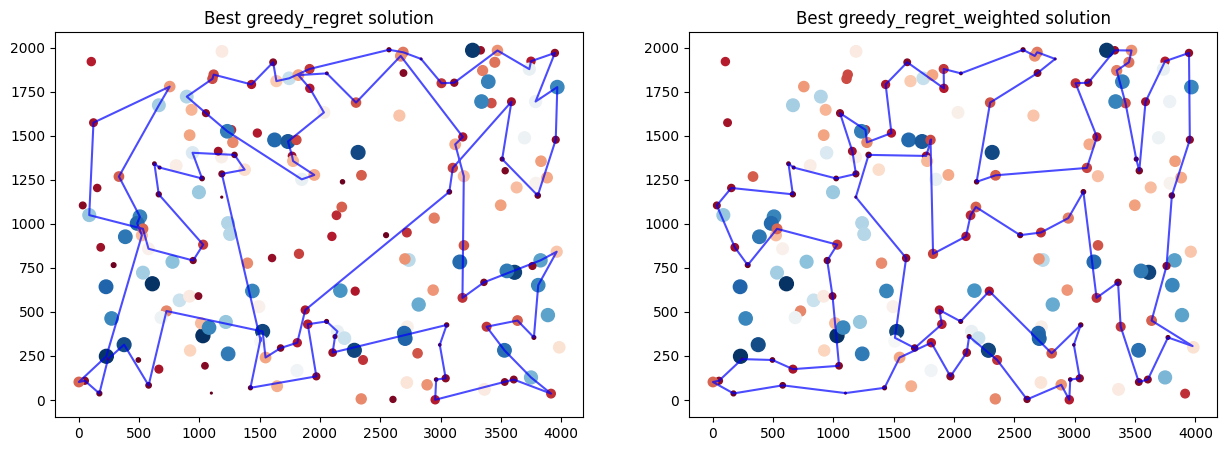

In [ ]:
get_solution('TSPA.csv')

Instance: TSPB.csv

greedy_regret results:

Max score: 137762
Average score: 124009.42
Min/Best score: 112191
Selected Nodes: [65, 173, 16, 106, 8, 195, 84, 117, 196, 191, 60, 21, 142, 13, 138, 48, 163, 17, 2, 172, 118, 95, 22, 135, 175, 145, 180, 157, 80, 36, 25, 134, 154, 194, 68, 43, 49, 50, 116, 0, 26, 92, 101, 31, 34, 183, 197, 11, 169, 66, 198, 136, 81, 185, 177, 18, 12, 139, 107, 97, 71, 78, 3, 156, 39, 91, 51, 70, 188, 140, 148, 141, 174, 155, 67, 126, 158, 166, 110, 72, 85, 59, 119, 193, 109, 104, 87, 89, 159, 35, 147, 187, 181, 189, 47, 100, 170, 76, 132, 52, 65]

greedy_regret_weighted results:

Max score: 72891
Average score: 71234.62
Min/Best score: 70089
Selected Nodes: [50, 24, 127, 121, 131, 103, 38, 101, 31, 179, 34, 183, 197, 143, 122, 92, 26, 5, 128, 66, 169, 0, 57, 135, 198, 19, 190, 95, 172, 16, 8, 115, 82, 63, 14, 18, 132, 52, 139, 21, 142, 141, 148, 140, 130, 174, 51, 70, 91, 156, 3, 192, 196, 117, 150, 158, 67, 114, 85, 72, 171, 58, 89, 129, 159, 147, 64, 166, 1

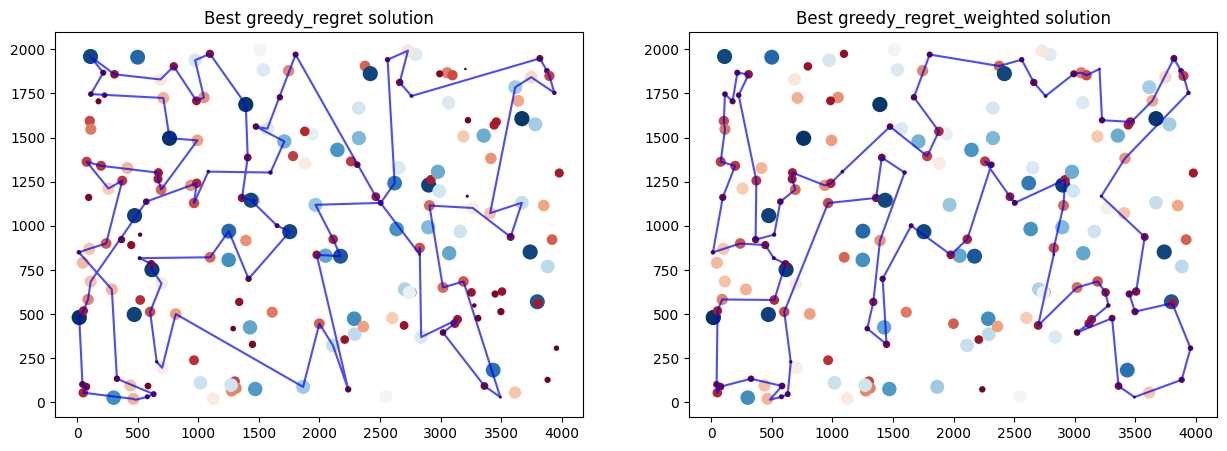

In [ ]:
get_solution('TSPB.csv')

Instance: TSPC.csv

greedy_regret results:

Max score: 84105
Average score: 78119.075
Min/Best score: 71143
Selected Nodes: [119, 109, 196, 5, 112, 172, 24, 141, 102, 87, 67, 184, 21, 157, 170, 129, 120, 62, 146, 32, 180, 81, 154, 133, 44, 144, 6, 156, 98, 190, 72, 42, 197, 111, 14, 107, 168, 80, 8, 95, 31, 51, 135, 91, 50, 149, 69, 38, 37, 143, 63, 96, 147, 27, 116, 70, 25, 166, 142, 61, 182, 7, 183, 56, 181, 85, 132, 36, 113, 163, 74, 195, 47, 117, 28, 22, 115, 0, 19, 43, 121, 114, 2, 4, 77, 189, 75, 1, 177, 41, 11, 160, 162, 16, 130, 92, 48, 52, 125, 13, 119]

greedy_regret_weighted results:

Max score: 59429
Average score: 56983.09
Min/Best score: 55052
Selected Nodes: [145, 161, 91, 114, 2, 4, 29, 175, 153, 88, 127, 186, 167, 101, 60, 83, 174, 126, 109, 99, 135, 51, 5, 112, 95, 169, 105, 124, 80, 123, 8, 110, 196, 134, 119, 26, 92, 106, 198, 48, 160, 11, 152, 130, 189, 75, 1, 177, 41, 137, 199, 150, 192, 77, 43, 121, 50, 149, 0, 115, 69, 19, 178, 164, 40, 128, 118, 132, 36, 113, 1

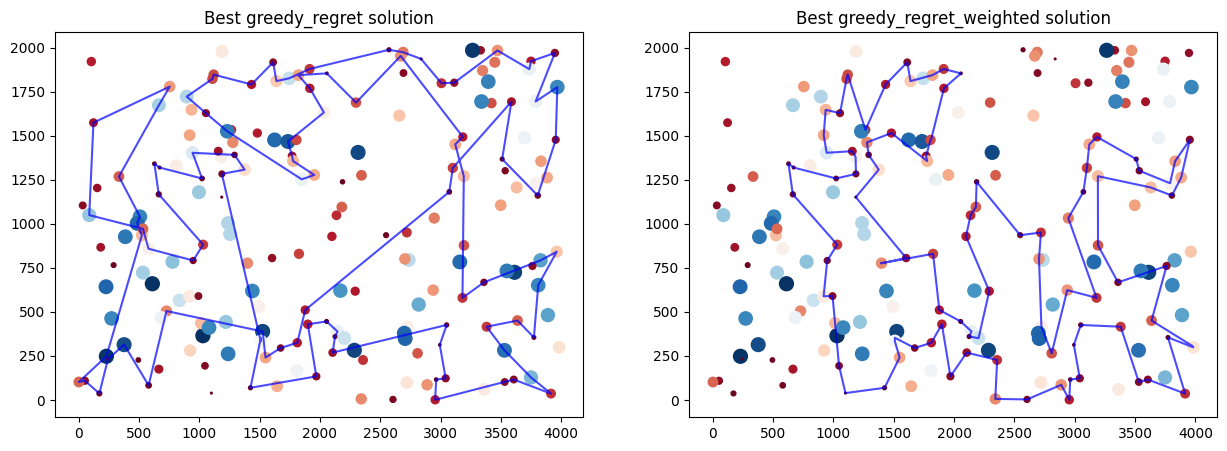

In [ ]:
get_solution('TSPC.csv')

Instance: TSPD.csv

greedy_regret results:

Max score: 83974
Average score: 76063.19
Min/Best score: 69473
Selected Nodes: [84, 82, 20, 69, 113, 32, 184, 13, 141, 148, 140, 188, 83, 70, 91, 51, 130, 142, 156, 71, 28, 64, 147, 159, 89, 129, 72, 85, 114, 193, 97, 139, 107, 187, 176, 181, 189, 47, 136, 61, 73, 177, 33, 6, 29, 18, 52, 173, 65, 16, 106, 22, 168, 198, 68, 36, 25, 134, 154, 194, 165, 37, 41, 102, 99, 116, 49, 112, 94, 50, 43, 167, 5, 31, 101, 1, 103, 131, 93, 125, 152, 179, 143, 197, 183, 122, 92, 27, 164, 0, 98, 135, 74, 172, 105, 2, 17, 8, 14, 7, 84]

greedy_regret_weighted results:

Max score: 59771
Average score: 55218.39
Min/Best score: 52066
Selected Nodes: [168, 29, 18, 33, 6, 136, 61, 73, 185, 132, 170, 100, 181, 47, 189, 109, 12, 107, 97, 59, 119, 193, 71, 44, 162, 158, 126, 45, 67, 114, 72, 85, 171, 58, 89, 129, 159, 147, 64, 28, 166, 110, 150, 117, 192, 155, 78, 3, 156, 91, 70, 51, 174, 161, 130, 188, 140, 148, 141, 13, 142, 53, 138, 21, 60, 196, 139, 52, 65, 14, 8

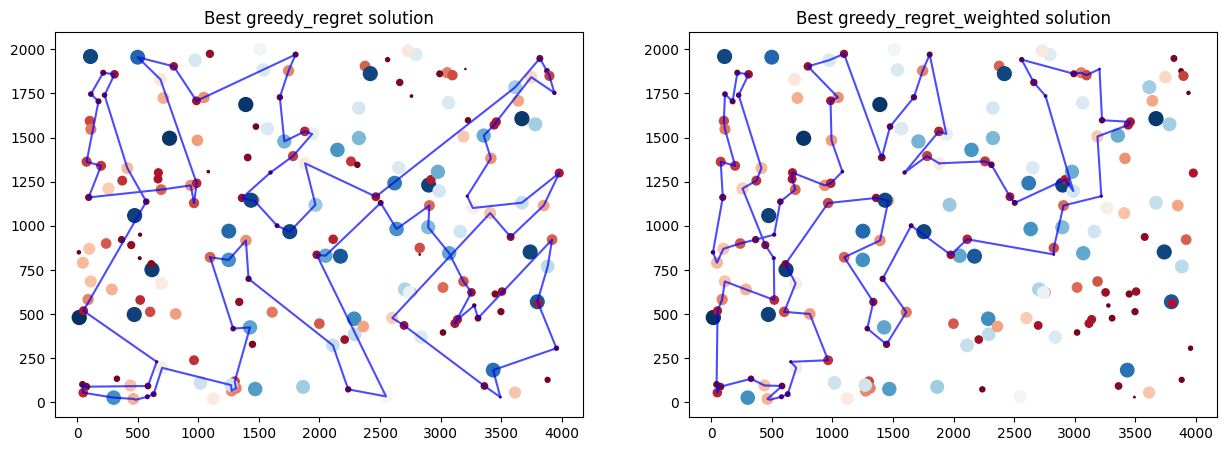

In [ ]:
get_solution('TSPD.csv')